In [1]:
import sys
sys.path.append("/s/ls4/users/grartem/RL_robots/continuous-grid-arctic/src")
sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
os.chdir("/s/ls4/users/grartem/RL_robots/RL_robotSim/")

In [3]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
import MyTfModel
import MyNewModels
%matplotlib inline

import MyMisc

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Prepare env and model

In [39]:
configs = pyhocon.ConfigFactory.parse_file("/s/ls4/users/grartem/RL_robots/RL_robotSim/Configs/FollowerContinuous/PPO_dyn_obst_2.conf")
#CONFIG = configs["ppo_e28_b1_f14v2_prev5_m_trans_v4v2"].as_plain_ordered_dict()
CONFIG = configs["ppo_e29_b2_f14VPC_mv4"].as_plain_ordered_dict()
CONFIG["config"]["num_workers"]=1

In [40]:
CONFIG["config"]["env_config"]["base_env_config"]

OrderedDict([('add_obstacles', True),
             ('max_distance', 4),
             ('warm_start', 0),
             ('max_steps', 10000),
             ('framerate', 5000),
             ('obstacle_number', 35),
             ('constant_follower_speed', False),
             ('corridor_length', 10),
             ('corridor_width', 1.5),
             ('move_bear_v4', True),
             ('follower_speed_koeff', 0.6),
             ('negative_speed', True),
             ('bear_speed_coeff', 1.2),
             ('early_stopping',
              OrderedDict([('max_distance_coef', 3.5), ('low_reward', -300)])),
             ('random_frames_per_step', [2, 20]),
             ('leader_speed_regime',
              OrderedDict([('0', [0.2, 1]),
                           ('200', 1),
                           ('1000', [0.5, 1]),
                           ('1500', 0.75),
                           ('2000', 0),
                           ('2500', 1),
                           ('3000', [0.5, 1]),
     

In [41]:
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LeaderPositionsTracker_v2"]["sensor_class"] = 'LeaderPositionsTracker_v2'
#CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LeaderPositionsTracker_v2"].pop("sensor_name")
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"].pop('LeaderCorridor_Prev_lasers_v2_compas')
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"].pop('LaserPrevSensor_compas')
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LaserPrevSensor_v2_compas_all"] = {
                                 "sensor_class": "LaserPrevSensor_v2_compas",
                                 "react_to_obstacles": True,
                                 "front_lasers_count": 6,
                                 "back_lasers_count": 6,
                                 "react_to_safe_corridor": True,
                                 "react_to_green_zone": True,
                                 "laser_length": 150,
                                 "use_prev_obs": True,
                                 "max_prev_obs": 5,
                                 "pad_sectors": False
}
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LaserPrevSensor_v2_compas_obst"] = {
                                 "sensor_class": "LaserPrevSensor_v2_compas",
                                 "react_to_obstacles": True,
                                 "front_lasers_count": 12,
                                 "back_lasers_count": 12,
                                 "react_to_safe_corridor": False,
                                 "react_to_green_zone": False,
                                 "laser_length": 200,
                                 "use_prev_obs": True,
                                 "max_prev_obs": 5,
                                 "pad_sectors": False
}
CONFIG["config"]["env_config"]["use_prev_obs"] = True
CONFIG["config"]["env_config"]["max_prev_obs"] = 5

In [42]:
EXPERIMENT_DIR = "/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_test_sensors/env29/PPO/default_model/feats_v14VPC/bear2/ppo_e29_b2_f14VPC_mv4/PPO_continuous-grid_399ae_00000_0_2023-07-21_14-24-58"
checkpoint_path = EXPERIMENT_DIR + "/checkpoint_000250/checkpoint-250"


In [43]:
trainer = ray.rllib.agents.registry.get_trainer_class(CONFIG["run"])(CONFIG["config"])
#trainer.restore(checkpoint_path)

env = MyMisc.continuous_env_maker(config=CONFIG["config"]["env_config"])

(RolloutWorker pid=39716) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=39716) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=39716) ===Запуск симуляции номер 0===
(RolloutWorker pid=39716) {'LeaderPositionsTracker_v2': <src.continuous_grid_arctic.utils.sensors.LeaderPositionsTracker_v2 object at 0x2ad73abed490>, 'LaserPrevSensor_v2_compas_all': <src.continuous_grid_arctic.utils.sensors.LaserPrevSensor_v2_compas object at 0x2ad73abed4f0>, 'LaserPrevSensor_v2_compas_obst': <src.continuous_grid_arctic.utils.sensors.LaserPrevSensor_v2_compas object at 0x2ad73abed3d0>}


(RolloutWorker pid=39716) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:329: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=39716)   warn(
(RolloutWorker pid=39716) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=39716)   logger.warn(
(RolloutWorker pid=39716) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=39716) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=39716) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=39716) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=39716) ALSA lib c

(RolloutWorker pid=39716) Model: "model"
(RolloutWorker pid=39716) __________________________________________________________________________________________________
(RolloutWorker pid=39716) Layer (type)                    Output Shape         Param #     Connected to                     
(RolloutWorker pid=39716) ==================================================================================================
(RolloutWorker pid=39716) observations (InputLayer)       [(None, 5, 36)]      0                                            
(RolloutWorker pid=39716) __________________________________________________________________________________________________
(RolloutWorker pid=39716) flatten (Flatten)               (None, 180)          0           observations[0][0]               
(RolloutWorker pid=39716) __________________________________________________________________________________________________
(RolloutWorker pid=39716) my_layer2 (Dense)               (None, 256)          46336

(RolloutWorker pid=39716) 2023-07-28 19:05:44,128	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=39716) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 36)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 180)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          46336       flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792  

2023-07-28 19:05:47,507	INFO trainable.py:124 -- Trainable.setup took 19.977 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-07-28 19:05:47,513	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [44]:
policy = trainer.get_policy()
print(type(policy))
print(type(policy.model))

<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>
<class 'MyNewModels.DefaultModelPrev'>


In [45]:
policy.model.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 36)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 180)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          46336       flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792       my_layer2[0][0]                  
______________________________________________________________________________________________

# Test episode

In [46]:
# Start env episode
seed_i = 7
env.seed(seed_i)
obs = env.reset()
done = False
total_reward = 0.0

===Запуск симуляции номер 0===
{'LeaderPositionsTracker_v2': <src.continuous_grid_arctic.utils.sensors.LeaderPositionsTracker_v2 object at 0x2ac6ae870a60>, 'LaserPrevSensor_v2_compas_all': <src.continuous_grid_arctic.utils.sensors.LaserPrevSensor_v2_compas object at 0x2acfb3049d00>, 'LaserPrevSensor_v2_compas_obst': <src.continuous_grid_arctic.utils.sensors.LaserPrevSensor_v2_compas object at 0x2acfb30210d0>}


In [47]:
# run N steps
NNobs_history, raw_obs_history, reward_history, info_history, actions_hist = [], [], [], [], []
obs_history = []
start_time = time.time()
for i in range(200):
    # Compute a single action, given the current observation
    # from the environment.
    NNobs_history.append(obs)
    raw_obs = env.env.env._get_obs()
    raw_obs_history.append({
        #'LeaderTrackDetector_radar': raw_obs['LeaderTrackDetector_radar'],
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        "numerical_features": raw_obs["numerical_features"]
    })
    
    pred_result = trainer.compute_single_action(obs, explore=False, full_fetch=True)
    action = pred_result[0]
    # Apply the computed action in the environment.
    obs, reward, done, info = env.step(action)
    #obs, reward, done, info = env.step([0.9, 0.0])
    obs_history.append(obs)
    
    actions_hist.append(action)
    reward_history.append(reward)
    info_history.append(info)
    # Sum up rewards for reporting purposes.
    total_reward += reward
    if done:
        break
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(elapsed_time)
#1:19

00:00:15


In [35]:
import joblib
raw_obs_history_new = joblib.load("raw_obs_history.new")
NNobs_history_new = joblib.load("NNobs_history.new")

In [17]:

raw_obs_history_old = joblib.load("raw_obs_history.old")
NNobs_history_old = joblib.load("NNobs_history.old")

In [21]:
len(NNobs_history)

858

In [37]:
for i in range(len(NNobs_history)):
    print((NNobs_history[i] - NNobs_history_new[i]).sum(), (NNobs_history[i] - NNobs_history_old[i]).sum())

0.0 0.0
0.03260986328124982 0.06423880259195969
0.07925071716308607 0.1499283981323244
0.11921901702880855 0.23623456319173175
-0.3007976404825853 -0.14554247538248705
-0.25646144866943366 -0.07688649495442634
0.25103904724121073 0.4897615559895834
0.2833253097534184 0.1106801986694343
-1.7190172322591148 -1.345819473266602
0.23705666859944663 -1.3507182947794587
0.14330361684163212 -1.1256478754679373
0.5127603022257492 0.7748547236124673
0.8873118082682302 1.152293078104655
0.15280704498291037 0.4025139363606765
0.3233986663818354 0.5026523081461587
1.1857304890950515 1.8254765319824213
2.613179092407227 3.221104227701823
1.6744976298014322 2.8808335876464852
-0.00905776977539069 2.6170761489868166
0.004400787353515734 2.3119174957275384
0.051526705423992625 1.5036615117390963
0.5319282023111975 0.06649017333984292
-0.5299208450317383 -0.010401916503907316
0.0289294815063475 0.06842988332112565
0.042369143168129786 0.10181674957275372
-0.4078061421712238 -0.33305310567219965
-0.88598

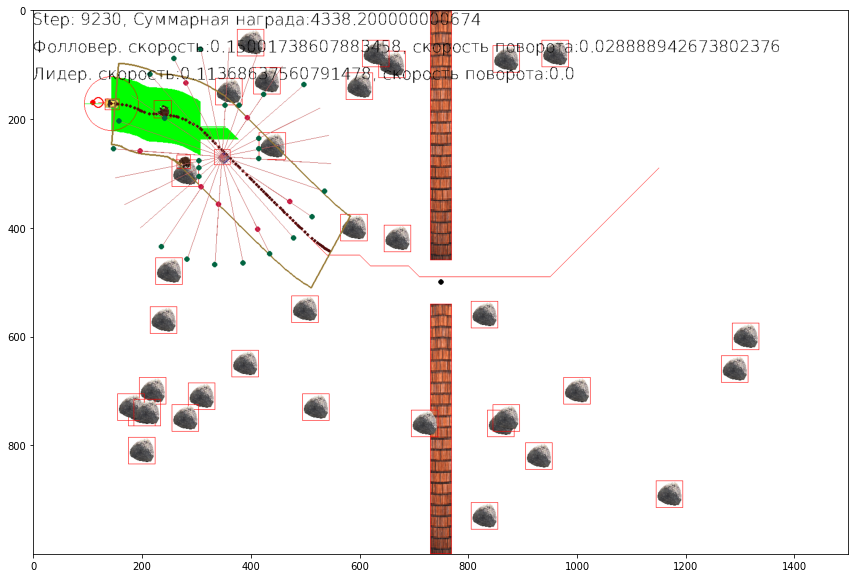

In [27]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

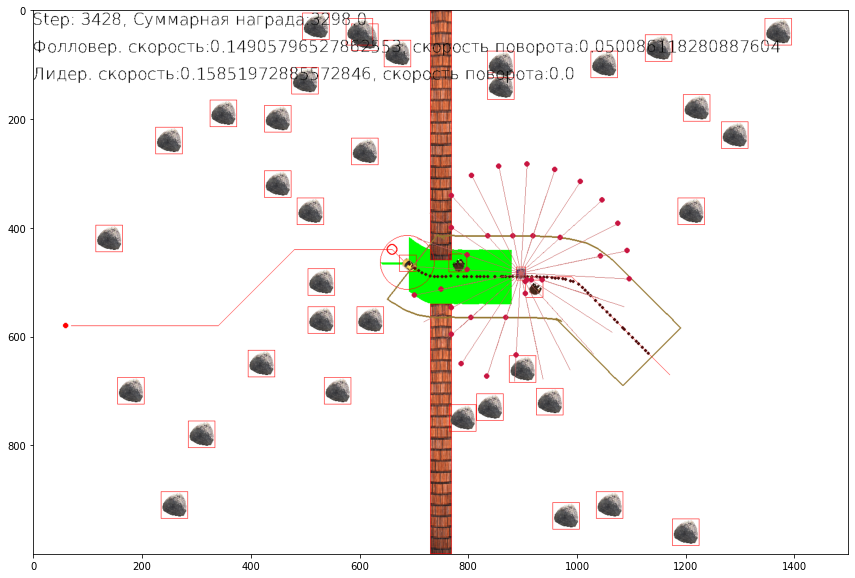

In [32]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [169]:
env.follower.rectangle.center, env.follower.position, env.env.env.game_dynamic_list[0].rectangle.center, env.env.env.game_dynamic_list[0].position

((1345, 743), array([1012.,  680.]), (1040, 530), (1340.0, 530.0))

In [ ]:
env.follower.rectangle.move()

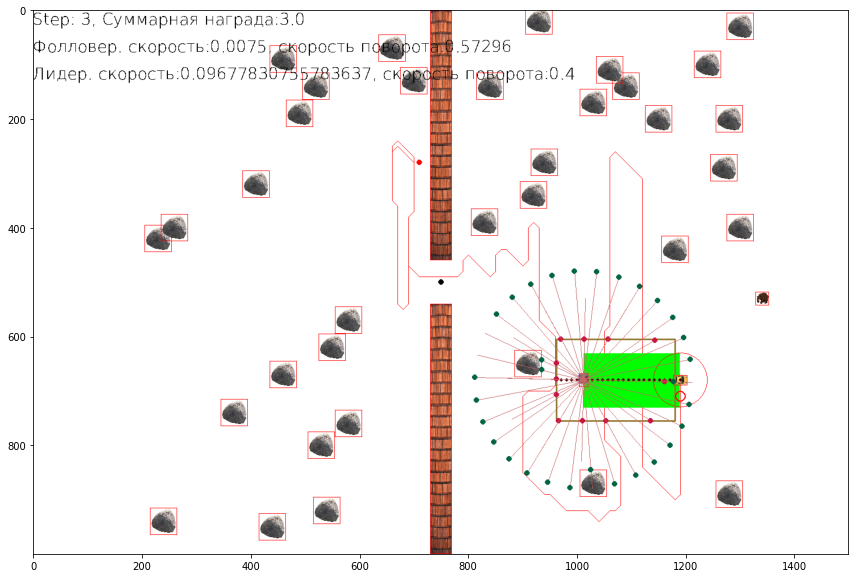

In [14]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))